# Notebook for quick analyisis of atomic coordinates using a SOAP based metric

In [1]:
#%reset
import numpy as np
from numpy import inf
from math import isnan
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

In [2]:
import sys
sys.path.append("/home/bingqing/repositories/ASAP/asap/")
import asaplib

In [3]:
from asaplib.plot import plot_styles
plot_styles.set_nice_font()

# setups for making plots
from matplotlib import cm

#norm = cm.colors.Normalize(vmax=30, vmin=0)
cmap = cm.summer

In [4]:
# units
kb2kcalmol = 0.0019872036 # kb*K to kcal_mol

## load structures

In [5]:
from ase.io import read,write

In [6]:
press="60"
foldername = "P-"+press+"GPa/"

In [7]:
# load the known structures
dictknownframes = read(foldername+"dict-knownphases/knownphases-pressure-"+press+"GPa-combined.xyz",':')
dictknowntags=np.loadtxt(foldername+"dict-knownphases/knownphases-pressure-"+press+"GPa-combined.list", dtype="str")
ndictknownframes = len(dictknownframes)
print("loaded", ndictknownframes,"frames")

loaded 13 frames


In [8]:
# load the newly founded structures in this work
dictnewframes = read(foldername+"dict-newphases/newphases-pressure-"+press+"GPa-combined.xyz",':')
dictnewtags=np.loadtxt(foldername+"dict-newphases/newphases-pressure-"+press+"GPa-combined.list", dtype="str")
ndictnewframes = len(dictnewframes)
print("loaded", ndictnewframes,"frames")

loaded 10 frames


In [9]:
# combine the two sets
dicttags = [y for x in [dictknowntags,dictnewtags] for y in x] 
ndict = ndictknownframes + ndictnewframes

In [10]:
# load the structures found in RSS
rssframes = read(foldername+"result-complete/combined.xyz",':')
tags = np.loadtxt(foldername+"result-complete/ranking-complete", dtype="str")
nrssframes = len(rssframes)
print("loaded", nrssframes,"frames")

#  import some reference order parameter for the structures
enthalpy = np.array(tags[:,3],float)
volume = np.array(tags[:,2],float)
symmetry = tags[:,6]
frequency = np.array(tags[:,-1],float)
nforms = np.array(tags[:,4],int)
ranks = np.arange(nrssframes)
dividenforms = 1./nforms
ground_state_enthalpy = float(tags[0,3])

global_nforms = set(nforms)
print("searched using nforms=",global_nforms)

loaded 4598 frames
searched using nforms= {2, 3, 4, 6, 8, 9}


In [11]:
frames = dictknownframes + dictnewframes + rssframes
global_species = []
for frame in frames:
    global_species.extend(frame.get_atomic_numbers())
global_species = np.unique(global_species)

nframes = len(frames)
print("a total of", nframes,"frames, with elements: ", global_species)

a total of 4621 frames, with elements:  [ 8 22]


# Build a kernel Matrix using DScribe lib

In [12]:
from dscribe.descriptors import SOAP
#from dscribe.kernels import REMatchKernel
from dscribe.kernels import AverageKernel

In [69]:
# set up the soap descriptors
soap_desc = SOAP(species=global_species,
                 rcut=4, nmax=6, lmax=6, sigma=0.5,
                 crossover=False, average=True,periodic=True)

In [70]:
fall = soap_desc.create(frames, n_jobs=8)

In [ ]:
fshape = np.shape(fall)
re = AverageKernel(metric="linear")
eva = re.create(fall.reshape((fshape[0],1, fshape[1])))

In [ ]:
np.savetxt("saved-kernels/pressure-"+press+"GPa-linear-SOAP-kernel.out", eva, fmt='%4.8f')

In [12]:
# if it has been computed before we can simply load it
eva = np.genfromtxt("saved-kernels/pressure-"+press+"GPa-linear-SOAP-kernel.out", dtype=float)
print("loaded","pressure-",press,"GPa-linear-SOAP-kernel.out")

### Alternatively, load the data coming from Glosim , creates a label list with each center's reference structure 
# load the kmatrix from glosim
#prefix = "pressure-"+press+"GPa-dict-complete-n8-l8-c4.0-g0.5_match_peratom"
#eva = np.genfromtxt(foldername+prefix+".k",skip_header=1)

loaded pressure- 60 GPa-linear-SOAP-kernel.out


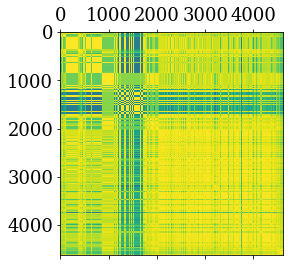

In [13]:
plt.matshow(eva)
plt.show()

# kernal PCA on environmental similarity

In [14]:
from asaplib.pca import kpca

In [15]:
proj = kpca(eva,10)

 - Centering the data 
  And now we build a projection 
Done, super quick. 


## kernel density estimation

In [16]:
from asaplib.kde import KDE

density_model = KDE()        
# fit density model to data
density_model.fit(proj)        
sigma_kij = density_model.bandwidth
rho = density_model.evaluate_density(proj)

Careful, you are trying to do density estimation for data in a D > 8 dimensional space
 ... you are warned !
[kde] Minimum bound = 0.0013 	 Rough estimate of h = 0.0131 	 Maximum bound = 0.0190
[kde] Bandwidth tolerance (xtol) set to precision of minimum bound : 0.00100 
[kde] Found log-likelihood maximum in 3 evaluations, h = 0.00190


## Quick plot of PCA results

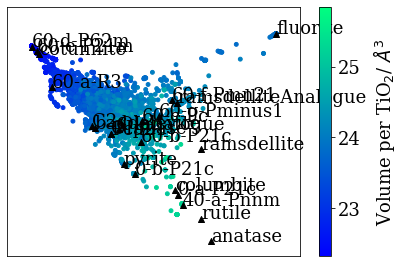

In [17]:
userho = False
useh = False
if (userho):
    plotcolor = rho[ndict:]
    colorlabel = 'local density of each data point'
elif (useh): # use entalpy as the color scheme
    plotcolor = enthalpy[:]
    colorlabel = 'Relative enthalpy per TiO$_2$ [Kcal/mol]'
else: # use molar volume as the color scheme
    plotcolor = volume[:]
    colorlabel = 'Volume per TiO$_2$/ $\AA^3$'
[ plotcolormin, plotcolormax ] = [ np.min(plotcolor),np.max(plotcolor) ]

d = [0,1]
#fig, ax = plt.subplots()
fig, ax = plot_styles.plot_density_map(proj[ndict:,d], plotcolor,
                xlabel=None, ylabel=None, 
                clabel=colorlabel, label=None,
                centers=None,
                psize=15,
                out_file=None, 
                title=None, 
                show=False, cmap='winter',
                remove_tick=True,
                use_perc=False,
                rasterized = True,
                fontsize = 15,
                vmax = plotcolormax,
                vmin = plotcolormin)

for i in range(ndict):
    ax.scatter(proj[i,d[0]],proj[i,d[1]],marker='^',c='black')
    ax.annotate(dicttags[i], (proj[i,d[0]], proj[i,d[1]]))
    
ax.tick_params(
    axis='x',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.tick_params(
    axis='y',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

            
#plt.title('KPCA and clustering at '+press+' GPa')
plt.tight_layout()
plt.show()
fig.set_size_inches(18.5*0.4, 10.5*0.4)
#fig.savefig('figures/KPCA-molarV-'+press+'GPa.png')

## DBSCAN

In [18]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler # we can scale the data first

"""
simple clustering schemes using DBSCAN
"""

# #############################################################################
# Generate sample data
X = proj[:,0:10]
# #############################################################################
# Compute DBSCAN
veps = 0.003
vminsamples = 3
db = DBSCAN(eps=veps, min_samples=vminsamples).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels_db = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_ = list(labels_db).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels_db))

Estimated number of clusters: 225
Estimated number of noise points: 1503
Silhouette Coefficient: 0.327


## Analysis of the properties of each cluster

In [19]:
from asaplib.cluster import get_cluster_size, get_cluster_properties
[ unique_labels, cluster_size ]  = get_cluster_size(labels_db[ndict:])
[ unique_labels, cluster_avg_enthalpy ]  = get_cluster_properties(labels_db[ndict:],enthalpy[:],'mean')
[ unique_labels, cluster_min_enthalpy ]  = get_cluster_properties(labels_db[ndict:],enthalpy[:],'min')
[ unique_labels, cluster_avg_nforms ]  = get_cluster_properties(labels_db[ndict:],nforms[:],'mean')
[ unique_labels, cluster_avg_molarvolume ]  = get_cluster_properties(labels_db[ndict:],volume[:],'mean')
[ unique_labels, cluster_symmetry ]  = get_cluster_properties(labels_db[ndict:],symmetry[:],'mode')

## Estimate the "entropy" for each cluster

In [21]:
found_clusters = np.unique(labels_db[ndict:])
found_clusters = found_clusters[found_clusters != -1]
print("index of clusters:", found_clusters)
n_found_clusters = len(found_clusters)
global_nforms = set(nforms)
print("searched using nforms=",global_nforms)

index of clusters: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224]
searched using nforms= {2, 3, 4, 6, 8, 9}


In [22]:
# count the number of found structures using nforms
structure_usingn = {}
for nf in global_nforms:
    structure_usingn[nf] = np.zeros(n_found_clusters,dtype=int)
for nf, cl in np.stack((nforms[:],labels_db[ndict:]),axis=-1):
    if (cl > -1): structure_usingn[nf][cl] += 1

In [23]:
structure_usingn[6]

array([  0,   0,   0,  65,   0,   0,   0,  20,   1,   0,  24,  20, 216,
        60,  37,   0,   0,   0,   0,   3,   0,   0,   0,   0,  86,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  12,   0,   0,  16,   0,
         3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        34,   0,   0,  14,   0,   0,   0,  13,   0,  13,   0,   0,   7,
         0,   0,   0,   0,   0,  14,   0,   0,   0,   0,   7,   6,   0,
         0,   9,   0,   5,   0,   0,   6,   0,   0,   0,   0,   0,   4,
         0,  10,  15,   0,   0,   0,   8,   0,  13,   0,   0,   3,   0,
        16,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         3,   0,   4,   4,   0,   0,   2,   0,   0,   1,   0,   0,   0,
         0,   0,   8,   6,   0,   5,   0,   0,   0,   0,   0,   6,   4,
         0,   0,   0,   0,   0,   7,   1,   5,   8,   5,   1,   0,   3,
         0,   0,   0,   0,   0,   4,   8,  15,   0,   3,   0,   

In [24]:
est_entropylist = np.log(structure_usingn[6]/max(structure_usingn[6]))/6.
est_entropy_noise = {}

for n1 in sorted(global_nforms,reverse=False):
    
    est_entropy_noise[n1] = np.log(1./max(structure_usingn[n1]))/n1
    
    if (sum(structure_usingn[n1])<2): continue
    # this is the relative est_entropy for TiO2 unit, that why we devide by n1
    tmp = np.log(structure_usingn[n1]/max(structure_usingn[n1]))/n1

    # align the data
    offset = 0.0
    nreal = 0
    for i in range(len(est_entropylist)): 
        if (est_entropylist[i] != -inf and tmp[i] != -inf): 
            offset += (tmp[i] - est_entropylist[i])
            nreal += 1
    offset /= nreal
    tmp = tmp - offset
    #print(n1,tmp)
    est_entropy_noise[n1] = est_entropy_noise[n1] - offset
    for i in range(len(est_entropylist)): 
        if (est_entropylist[i] == -inf): 
            est_entropylist[i] = tmp[i]
        elif (tmp[i] != -inf): 
            est_entropylist[i] = (tmp[i]+est_entropylist[i])/2.

# set the average to zero
est_entropylist = est_entropylist-np.mean(est_entropylist)
#print(est_entropylist) 

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [25]:
entropy_basin = np.zeros(nframes,dtype=float)
for i in range(nframes):
    cl = labels_db[i]
    if (cl == -1 and i>=ndict):
        nf = nforms[i-ndict]
        entropy_basin[i] = est_entropy_noise[nf]
    else:
        entropy_basin[i] = est_entropylist[cl]

In [26]:
# we record a list of samples with finite entropy
sb_list=[]
for i,sb in enumerate(entropy_basin):
    if (i>=ndict and np.isfinite(sb)):
        sb_list.append(i)
sb_list = np.asarray(sb_list)

## make plots of the KPCA + clustering

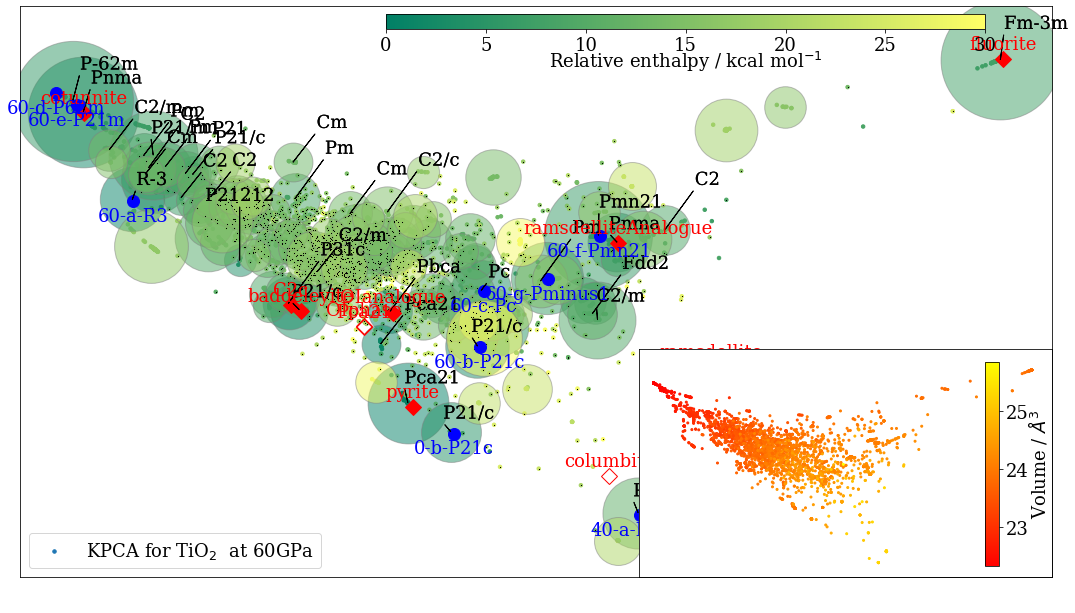

In [38]:
# make plot
d = [0,1]
[ unique_labels, cluster_x ]  = get_cluster_properties(labels_db[ndict:],proj[ndict:,d[0]],'mean')
[ unique_labels, cluster_y ]  = get_cluster_properties(labels_db[ndict:],proj[ndict:,d[1]],'mean')

maxe = 30.

fig, ax = plt.subplots()
#fig1, (ax, subax) = plt.subplots( 2)
# all unknown structures
cset1 = ax.scatter(proj[ndict:, d[0]], proj[ndict:, d[1]],  c=enthalpy[:],
            cmap=cm.get_cmap(cmap),vmin=0,vmax=maxe, marker='o', s=12, label="KPCA for TiO$_2$  at "+press+ "GPa")
ax.legend(loc='lower left')

cbaxes = fig.add_axes([0.4, 0.85, 0.45, 0.02])
cbar=fig.colorbar(cset1, cax=cbaxes, orientation='horizontal')
cbar.ax.set_xlabel('Relative enthalpy / kcal mol$^{-1}$',labelpad=-5)

# plot the clusters with size propotional to population
# use the average enthalpy for the color scale
cluster_colors = [cmap(cluster_avg_enthalpy[each]/maxe)
          for each in unique_labels]
for k, col in zip(unique_labels, cluster_colors):
    ms = 20.0*(np.log(cluster_size[k]))
    if (k >=0 and cluster_size[k]>4):
        ax.plot(cluster_x[k],cluster_y[k], 'o', markerfacecolor=tuple(col), alpha =0.5,
            markeredgecolor='gray', markersize=ms)
        #print (cluster_x[k],cluster_y[k],cluster_size[k])
        # symmetry
        if (cluster_size[k]> 15 and cluster_avg_enthalpy[k]< 15 
            and cluster_symmetry[k] != 'P-1' and cluster_symmetry[k] != 'P1') :
            txt = ax.annotate(cluster_symmetry[k], xy=(cluster_x[k],cluster_y[k]), 
                         xytext=(0.3*ms,0.3*ms), 
                     textcoords='offset points', color='black',
                      horizontalalignment='center', verticalalignment='center',
                         arrowprops=dict(width=0.01, facecolor='blue', headlength=0.01, headwidth=0.01))
            
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=20, foreground='none'),
                PathEffects.Normal()])
            
        elif (cluster_size[k]> 5 and cluster_avg_enthalpy[k]< 15 
            and cluster_symmetry[k] != 'P-1' and cluster_symmetry[k] != 'P1') :
            txt = ax.annotate(cluster_symmetry[k], xy=(cluster_x[k],cluster_y[k]), 
                         xytext=(ms*0.6,ms*1.0), 
                        textcoords='offset points', color='black',
                      horizontalalignment='left', verticalalignment='center',
                         arrowprops=dict(width=0.01, facecolor='blue', headlength=0.01, headwidth=0.01))
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=20, foreground='none'),
                PathEffects.Normal()])
                        
        elif (cluster_size[k]> 2 and cluster_avg_enthalpy[k]< 10 
            and cluster_symmetry[k] != 'P-1' and cluster_symmetry[k] != 'P1') :
            txt = ax.annotate(cluster_symmetry[k], xy=(cluster_x[k],cluster_y[k]), 
                          xytext=(0,ms*2), 
                            textcoords='offset points', color='black',
                      horizontalalignment='center', verticalalignment='center',
                         arrowprops=dict(width=0.01, facecolor='blue', headlength=0.01, headwidth=0.01))
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=20, foreground='none'),
                PathEffects.Normal()])
            

    # the noisy points
    if k == -1:
        # Black removed and is used for noise instead.
        # Black used for noise.
        col = [0, 0, 0, 1]
        class_member_mask = (labels_db == k)
        xy = X[class_member_mask & ~core_samples_mask]
        ax.plot(xy[ndict:, d[0]], xy[ndict:, d[1]], 'x', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=0.5)
    
# reference known structures
for i in range(ndictknownframes):
    if (labels_db[i] >= 0):
        ax.plot(proj[i,d[0]],proj[i,d[1]],marker='D',c='red', markersize=12)
    else: ax.plot(proj[i,d[0]],proj[i,d[1]],marker='D',markerfacecolor='none',
             markeredgecolor='red',markersize=12)
        #ax.annotate(dicttags[i], (proj[i,d[0]], proj[i,d[1]]))
    txt = ax.annotate(dicttags[i], xy=(proj[i,d[0]], proj[i,d[1]]), 
                 xytext=(0,15), textcoords='offset points', color='red',
                      horizontalalignment='center', verticalalignment='center')

# reference new structures
for i in range(ndictknownframes+1,ndict):
    if (labels_db[i] >= 0):
        ax.plot(proj[i,d[0]],proj[i,d[1]],marker='o',c='blue', markersize=12)
    else: ax.plot(proj[i,d[0]],proj[i,d[1]],marker='o',markerfacecolor='none',
             markeredgecolor='blue',markersize=12)
        #ax.annotate(dicttags[i], (proj[i,d[0]], proj[i,d[1]]))
    txt = ax.annotate(dicttags[i], xy=(proj[i,d[0]], proj[i,d[1]]), 
                 xytext=(0,-15), textcoords='offset points', color='blue',
                      horizontalalignment='center', verticalalignment='center')
    
axislimitat0Gpa = [[-0.095,0.08],[-0.09,0.086]]
axislimitat20Gpa = [[-0.06,0.09],[-0.099,0.086]]
axislimitat40Gpa = [[-0.06,0.09],[-0.08,0.056]]
axislimitat60Gpa = [[-0.05,0.089],[-0.075,0.045]]

al = axislimitat60Gpa
ax.set_xlim(al[0][0],al[0][1])
ax.set_ylim(al[1][0],al[1][1])

ax.tick_params(
    axis='x',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.tick_params(
    axis='y',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off


#plt.tight_layout()

# embed another subplot
subpos = [0.6,0.00,0.4,0.4]
subax = plot_styles.add_subplot_axes(ax,subpos)

cset2 = subax.scatter(proj[ndict:, d[0]], proj[ndict:, d[1]],  c=volume[:],
            cmap='autumn', marker='o', s=4)

subax.tick_params(
    axis='x',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
subax.tick_params(
    axis='y',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
subax.set_xlim(al[0][0],al[0][1])
subax.set_ylim(al[1][0],al[1][1])
subcbaxes = fig.add_axes([0.85, 0.14, 0.01, 0.27])
subcbar=fig.colorbar(cset2, cax=subcbaxes)
subcbar.ax.set_ylabel('Volume / $\AA^3$',labelpad=-2)

#plt.title('KPCA and clustering at '+press+' GPa')
fig.set_size_inches(18.5, 10.5)

#plt.tight_layout()

fig.savefig('figures/KPCA-cluster-'+press+'GPa-v2.png', transparent=True)

In [39]:
from asaplib.cluster import output_cluster, output_cluster_sort

output_cluster("DBSCAN-"+press+"-GPa",labels_db,dicttags,tags)
output_cluster_sort("DBSCAN-"+press+"-GPa",labels_db,dicttags,tags)

0

# Read reference properties

In [40]:
from scipy.interpolate import interp1d

In [41]:
tlist = [700, 1600]

mufunc = {}
hfunc ={}
    
for tnow in tlist:
    
    # initialize the dictionaries
    mufunc[tnow] = {'system':'0'}
    hfunc[tnow] = {'system':'0'}
    
    # read in the list of systems
    systemlist = np.loadtxt("ref-energy/chemPot-MA-"+str(tnow)+"K-in-kcal-per-formula-unit.dat", dtype="str")[0,1:]
    print("at T=", tnow, "we have:", systemlist)
    
    # read in the chemical potential
    # pressure in units GPa, mu in units kcal-per-formula-unit
    mulist = np.genfromtxt("ref-energy/chemPot-MA-"+str(tnow)+"K-in-kcal-per-formula-unit.dat", dtype="str")[:,:]
    mupressurelist = [float(i) for i in mulist[1:,0]] 
    
    # read in the enthalpy
    # pressure in units GPa, mu in units kcal-per-formula-unit
    hlist = np.genfromtxt("ref-energy/enthalpy-MA-"+str(tnow)+"K-in-kcal-per-formula-unit.dat", dtype="str")[:,:]
    hpressurelist = [float(i) for i in hlist[1:,0]] 

    # fill in the data
    for x in systemlist:
        # chemical potential
        xliststr = np.asarray([p for p in mulist.T if p[0]==x])
        xlist = [float(i) for i in xliststr[0,1:]]
        mufunc[tnow][x] = interp1d(mupressurelist, xlist)
        # enthalpy    
        xliststr = np.asarray([p for p in hlist.T if p[0]==x])
        xlist = [float(i) for i in xliststr[0,1:]]
        hfunc[tnow][x] = interp1d(hpressurelist, xlist)

at T= 700 we have: ['anatase' 'baddeleyite' 'brookite' 'columbite' 'cotunnite' 'C2c'
 'fluorite' 'hollandite' '0-a-P21c' '0-b-P21c' '0-c-I41a' '0-d-P31m'
 '0-e-C2c' '0-f-C2m' '0-g-Im2m' '40-a-Pnnm' '60-a-R3' '60-b-P21c'
 '60-c-Pc' '60-d-P62m' '60-e-P21m' '60-f-Pmn21' '60-g-Pminus1'
 'OIanalogue' 'pyrite' 'ramsdelliteAnalogue' 'rutile' 'TiO2B']
at T= 1600 we have: ['anatase' 'baddeleyite' 'brookite' 'columbite' 'cotunnite' 'C2c'
 'fluorite' 'hollandite' '0-a-P21c' '0-b-P21c' '0-c-I41a' '0-d-P31m'
 '0-e-C2c' '0-f-C2m' '0-g-Im2m' '40-a-Pnnm' '60-a-R3' '60-b-P21c'
 '60-c-Pc' '60-d-P62m' '60-e-P21m' '60-f-Pmn21' '60-g-Pminus1'
 'OIanalogue' 'pyrite' 'ramsdelliteAnalogue' 'rutile' 'TiO2B']


In [42]:
# compile a dictionary for the reference properties of all structures
pressurelist = [0,20,40,60]
enthalpydict = {}
mudict = {}
entropydict = {}

for tnow in tlist:
    kbt = kb2kcalmol*tnow
    
    enthalpydict[tnow] = {'p':{'system':0}}
    mudict[tnow] = {'p':{'system':0}}
    entropydict[tnow] = {'p':{'system':0}}
    
    for pnow in pressurelist:
        # we use the structure with the lowest enthalpy as a baseline
        ground_state_enthalpy = inf
        ground_state_system = 'unkown'
        
        for x in systemlist:
            enthalpynow = hfunc[tnow][x](pnow)
            if (enthalpynow < ground_state_enthalpy):
                ground_state_enthalpy = enthalpynow
                ground_state_system = x
        ground_state_mu = mufunc[tnow][ground_state_system](pnow)
        ground_state_entropy = (ground_state_enthalpy-ground_state_mu)/kbt
        enthalpydict[tnow][pnow] = {'ground_state': ground_state_enthalpy}
        mudict[tnow][pnow] = {'ground_state': ground_state_mu}
        entropydict[tnow][pnow] = {'ground_state': ground_state_entropy}
        
        for x in systemlist:
            enthalpynow = hfunc[tnow][x](pnow)-hfunc[tnow][ground_state_system](pnow)
            munow = mufunc[tnow][x](pnow)-mufunc[tnow][ground_state_system](pnow)
            snow = (enthalpynow-munow)/kbt
            
            enthalpydict[tnow][pnow].update({x: enthalpynow})
            mudict[tnow][pnow].update({x: munow})
            entropydict[tnow][pnow].update({x: snow})

# Estimate the "entropy" for found strucures

In [43]:
# compile a list of found structures
structuresfound = []
for i in range(ndict):
    ll = dicttags[i]
    if (labels_db[i] >= 0 and ll in systemlist):
        ll = dicttags[i]
        #print(ll,cluster_avg_natoms[i],cluster_size[i])
        cl = labels_db[i]
        structuresfound.append([ll,cl,est_entropylist[cl]])

In [44]:
# we use this sequence for the following analysis
print(structuresfound)

[['baddeleyite', 0, 0.007882393132530252], ['C2c', 1, 0.14841722000127067], ['cotunnite', 2, 0.5069863209262312], ['fluorite', 3, 0.31237876075609705], ['OIanalogue', 4, 0.09318812596639081], ['pyrite', 5, 0.18541948384214513], ['ramsdelliteAnalogue', 6, 0.030414855407783103], ['0-b-P21c', 7, 0.2559278531657456], ['40-a-Pnnm', 8, -0.19779327758387977], ['60-a-R3', 9, 0.29911924013215224], ['60-b-P21c', 10, 0.28631477929807136], ['60-c-Pc', 11, 0.2559278531657456], ['60-d-P62m', 12, 0.38356427944232485], ['60-e-P21m', 12, 0.38356427944232485], ['60-f-Pmn21', 13, 0.30078657262769637], ['60-g-Pminus1', 14, 0.35845879301411787]]


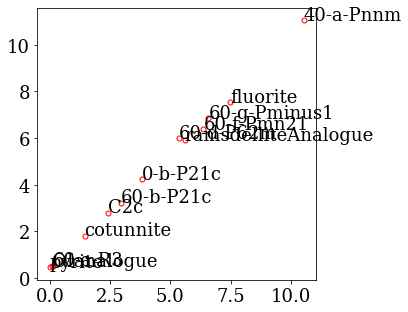

In [45]:
# first let's compare the enthalpy at 0K and at high T
fig, axs = plt.subplots()

cluster_avg_enthalpy_min = inf
cluster_avg_enthalpy_min_name = 'unknown'
cluster_avg_enthalpy_min_index = 0

for index,[ll,k,_] in enumerate(structuresfound):

    tnow = 1600

    enthalpynow = enthalpydict[tnow][int(press)][ll]
    if (cluster_avg_enthalpy[k] < cluster_avg_enthalpy_min):
        cluster_avg_enthalpy_min = cluster_avg_enthalpy[k]
        cluster_avg_enthalpy_min_name = ll
        cluster_avg_enthalpy_min_index = index

    #print(k,ll, enthalpynow , cluster_avg_enthalpy[k]) # compare actual H at finite T and the ground state H
    axs.plot(enthalpynow , cluster_avg_enthalpy[k], 'o', markerfacecolor='none', markeredgewidth=1,
            markeredgecolor='r', markersize=5)
    if (not np.isnan(enthalpynow)): plt.annotate(ll, xy=(enthalpynow , cluster_avg_enthalpy[k]))
fig.set_size_inches(5, 5)

## make a comparison between log(n_found) and actual entropy

In [46]:
error_est_entropy = 0

for tnow in tlist:
    xfitlist = []
    yfitlist = []
    for [ll,k,sb] in structuresfound:
        snow = entropydict[tnow][int(press)][ll]
        if(isnan(sb) or isnan(snow)): 
            continue
        else:
            xfitlist.append(snow)
            yfitlist.append(sb)

    xfitlist = xfitlist-np.mean(xfitlist)
    yfitlist = yfitlist-np.mean(yfitlist)   
    difflist = [(i - j)**2. for i, j in zip(xfitlist, yfitlist)]
    error_est_entropy += np.sqrt(np.mean(difflist))
error_est_entropy /= len(tlist)
print(error_est_entropy)

0.1747048844493964


In [47]:
# this is just to align the data, because only the relative diff in entropy matters
entropy_offset={}

for tnow in tlist:
    kbt = kb2kcalmol*tnow # in kcal/mol
    sdif = 0.0 
    snum = 0
    for [ll,k,sb] in structuresfound:
        munow = mudict[tnow][int(press)][ll]
        enthalpynow = cluster_min_enthalpy[k]
        snow = (enthalpynow-munow)/kbt
        
        if (not np.isnan(snow)): 
            sdif += (snow-sb)
            snum += 1
        #print(sdif,snow, est_entropylist[index])
    entropy_offset[tnow] = sdif/snum
print(entropy_offset)

{700: -0.2876321552711537, 1600: -0.2415394479073836}


In [48]:
f = open("entropy-compare/entropy-compare-P-"+str(press)+"GPa.dat", "w")
f.write("# T[K] name S_b=log(frequency)[per-TiO2] (enthalpy0K-mu(T))/kbT[per-TiO2] (enthalpy(T)-mu(T))/kbT[per-TiO2]\n")

for tnow in tlist:
    for [ll,k,sb] in structuresfound:
        
        # use enthalpy at 0K
        munow = mudict[tnow][int(press)][ll]
        enthalpynow = cluster_min_enthalpy[k]
        #this is enthalpy[0K] - mu
        snow = (enthalpynow-munow)/kbt-entropy_offset[tnow]
        
        # this is enthalpy[tnow] - mu
        snowatT = entropydict[tnow][int(press)][ll]
        #print(tnow, ll, est_entropylist[index],snow, snowatT)
        f.write("%d %s %4.4f %4.4f %4.4f\n"%(tnow, ll, sb,snow, snowatT))
f.close()

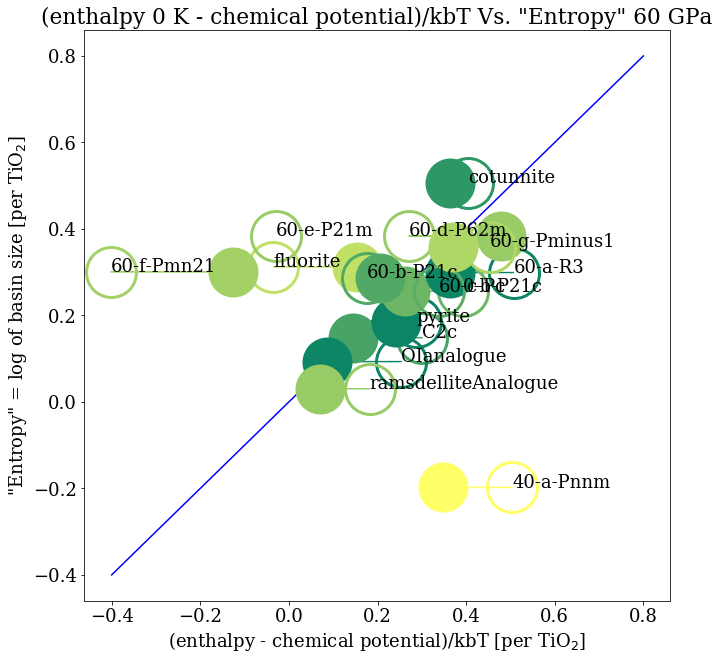

In [49]:
fig, axs = plt.subplots()

tnow = 1600
kbt = kb2kcalmol*tnow # in kcal/mol
    
maxe = 10.
cluster_colors = [cmap((cluster_avg_enthalpy[each[1]])/maxe)
          for each in structuresfound]

xplotrange = np.linspace(-0.4,0.8,num=100)
axs.plot(xplotrange,xplotrange,'b-')

for index,[ll,k,sb] in enumerate(structuresfound):
    
    # low T
    tnow = 700
    kbt = kb2kcalmol*tnow # in kcal/mol

    # we can use
    munow = mudict[tnow][int(press)][ll]
    enthalpynow = cluster_min_enthalpy[k]
    #print(munow,enthalpynow)
    snow = (enthalpynow-munow)/kbt-entropy_offset[tnow]
    [lowT_x,lowT_y] = [snow, sb] # compare actual S and the approximation of RSS 
    #print(ll,snow, est_entropylist[index])
    #axs.scatter(x,y,  marker='o', s=500) #,  c=enthalpynow)#, cmap=cm.get_cmap(cmap, 100),vmin=0,vmax=10,  s=50)
    axs.plot(lowT_x,lowT_y, 'o', markerfacecolor='none', markeredgewidth=3,
            markeredgecolor=tuple(cluster_colors[index]), markersize=50)
    if (not np.isnan(lowT_x)): plt.annotate(ll, xy=(lowT_x,lowT_y))
    
    #axs.plot(xplotrange,ssfit[tnow](xplotrange),'g--')
    
    # high T
    tnow = 1600
    kbt = kb2kcalmol*tnow # in kcal/mol
    
    munow = mudict[tnow][int(press)][ll]
    enthalpynow = cluster_min_enthalpy[k]
    snow = (enthalpynow-munow)/kbt-entropy_offset[tnow]
    [highT_x,highT_y] = [snow, sb] # compare actual S and the approximation of RSS 
    axs.arrow(lowT_x,lowT_y,highT_x-lowT_x,0,color=cluster_colors[index])
    axs.plot(highT_x,highT_y, 'o', markerfacecolor=tuple(cluster_colors[index]),
            markeredgecolor='none', markersize=50)
    #if (not np.isnan(x)): plt.annotate(ll, xy=(x,y))
    

plt.xlabel('(enthalpy - chemical potential)/kbT [per TiO$_2$]')
plt.ylabel('"Entropy" = log of basin size [per TiO$_2$]')
plt.title('(enthalpy 0 K - chemical potential)/kbT Vs. "Entropy" '+press+' GPa')
fig.set_size_inches(10.5, 10.5)

fig.savefig('figures/mu-basinsize-'+press+'GPa.png')

## KRR for property prediction

### first do a FPS

Widget Javascript not detected.  It may not be installed or enabled properly.


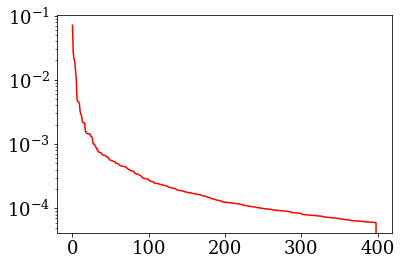

In [50]:
from asaplib.compressor import fps, fast_fps
kNN = eva[ndict:,ndict:]
ntot = len(kNN)
ifps, dfps = fps(kNN,400, 0)
#fifps, fdfps, fivor, frvor = fast_fps(eva,200, 0)
#print(ifps)
plt.semilogy(dfps,'r-')

In [51]:
nkeep = 200
for i in ifps[:nkeep]+ndict:
    write('FPS-xyz/fps-P'+press+'.xyz',frames[i], append=True)

In [52]:
nref = 200
kMM = kNN[ifps[:nref],ifps[:nref]]
print(ntot, nref)

kNM = kNN[:,ifps[:nref]]
kMM=kNN[:,ifps[:nref]][ifps[:nref]]

4598 200


### krr for enthalpy

55.20025430376995


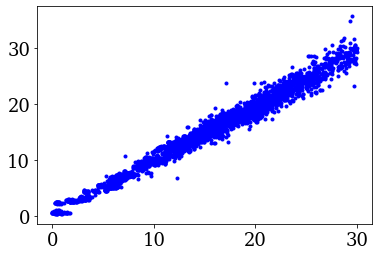

In [59]:
y_enthalpy_train = enthalpy[:]

sparse_jitter = 1e-10
delta = np.var(y_enthalpy_train)/(np.trace(kMM)/nref)
sigma = 0.3
sparseK = kMM * delta * sigma**2 +  np.dot(kNM.T,kNM)*delta**2
sparseY = delta*np.dot(delta*kNM.T,y_enthalpy_train)
w_enthalpy = np.linalg.solve(sparseK+np.eye(nref)*sparse_jitter, sparseY)
print(delta)

y_enthalpy_pred = np.dot(kNM,w_enthalpy)
y_enthalpy_abs_error = np.sqrt((y_enthalpy_train - y_enthalpy_pred)**2.)
plt.plot(y_enthalpy_train, y_enthalpy_pred, 'b.')

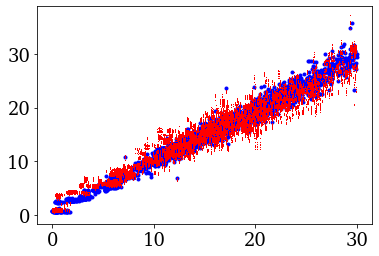

In [60]:
# error estimation using bootstrap
bslist_enthalpy = []
nbs = 8
for ibs in range(nbs):
    idx = np.asarray(range(ntot))
    sbs = np.random.choice(idx, 600, replace =False)
    #print sbs
    subkNM = kNM[sbs,:]
    sparseK = kMM * delta * sigma**2 +  np.dot(subkNM.T,subkNM)*delta**2
    sparseY = delta*np.dot(delta*subkNM.T,y_enthalpy_train[sbs])
    subw = np.linalg.solve(sparseK+np.eye(nref)*sparse_jitter, sparseY)
    suby_pred = np.dot(kNM,subw)
    bslist_enthalpy.append({"selection": sbs, "w": subw,"prediction": suby_pred})
    
plt.plot(y_enthalpy_train,y_enthalpy_pred,'b.')
for ibs in range(nbs):
    plt.plot(y_enthalpy_train,bslist_enthalpy[ibs]['prediction'],'r,')

{'MAE': 0.5647295499791047, 'RMSE': 0.8285830808747221, 'SUP': 6.454655414472021, 'R2': -0.6289885942838795, 'CORR': 0.2329223567018694}
[2.03036998 0.34607133]


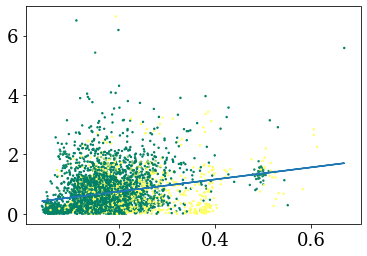

In [61]:
from asaplib.fit import get_score
# get the correlation coefficient between the true error and the predicted error
n_train = len(y_enthalpy_train)
y_enthalpy_pred_error = np.zeros(n_train)
for i in range(n_train):
    y_enthalpy_pred_error[i] = np.std([bslist_enthalpy[ibs]['prediction'][i] for ibs in range(nbs)])
print(get_score(y_enthalpy_pred_error,y_enthalpy_abs_error))

z = np.polyfit(y_enthalpy_pred_error,y_enthalpy_abs_error, 1)
print(z)
errorfit_enthalpy = np.poly1d(z)
plt.scatter(y_enthalpy_pred_error,y_enthalpy_abs_error, c=labels_db[ndict:],
            cmap=cm.get_cmap(cmap, 100),vmin=0,vmax=100, marker='o',s=2)
plt.plot(y_enthalpy_pred_error,errorfit_enthalpy(y_enthalpy_pred_error))

In [62]:
# prediction on the known possible structures in the dictionary
kXM = eva[:ndict,ifps[:nref]+ndict]

y_enthalpy_test = np.dot(kXM,w_enthalpy)
suby_enthalpy_test = np.zeros((nbs,len(y_enthalpy_test)))
for ibs in range(nbs):
    suby_enthalpy_test[ibs,:]=np.dot(kXM,bslist_enthalpy[ibs]['w'])

In [63]:
y_test_result = np.zeros((ndict,7))
for i in range(ndict):
    cl = labels_db[i]
    y_test_result[i,0] = i
    y_test_result[i,-1] = cl
    if( cl >= 0): 
        # if the structure has been found, we take the mean of the enthalpy of the cluster
        y_test_result[i,1] = cluster_min_enthalpy[labels_db[i]] # mean of enthalpy
        y_test_result[i,2] = cluster_avg_enthalpy[labels_db[i]] -cluster_min_enthalpy[labels_db[i]]
    else:
        # if the structure hasn't been found, we use the KRR to predict its enthalpy
        y_test_result[i,1] = y_enthalpy_test[i] # mean of enthalpy
        y_test_result[i,2] = errorfit_enthalpy(np.std(suby_enthalpy_test[:,i])) # error estimate of enthalpy  
    
    
    print(i,cl,  dicttags[i], y_test_result[i,[1,2]])

0 -1 anatase [38.95154748  2.01857398]
1 0 baddeleyite [3.102      0.20916667]
2 1 C2c [2.587      0.21885714]
3 -1 columbite [10.87891452  1.31916632]
4 2 cotunnite [1.349      0.46857708]
5 3 fluorite [6.517      1.00483202]
6 4 OIanalogue [0.33       0.17922222]
7 -1 OIphase [15.6213853  0.8381797]
8 -1 Pca21 [8.04762992 0.72373587]
9 5 pyrite [0.         0.45210526]
10 6 ramsdelliteAnalogue [5.588      0.31552632]
11 -1 ramsdellite [21.74768315  1.49336547]
12 -1 rutile [15.82455537  1.56321663]
13 -1 0-a-P21c [11.74503898  1.26824442]
14 7 0-b-P21c [3.912   0.31435]
15 8 40-a-Pnnm [10.708       0.33374286]
16 9 60-a-R3 [0.286  0.2448]
17 10 60-b-P21c [2.66       0.57170833]
18 11 60-c-Pc [3.279  0.2407]
19 12 60-d-P62m [4.772      1.21786308]
20 12 60-e-P21m [4.772      1.21786308]
21 13 60-f-Pmn21 [5.32       1.05351584]
22 14 60-g-Pminus1 [6.531      0.32256757]


### KRR for entropy

Widget Javascript not detected.  It may not be installed or enabled properly.


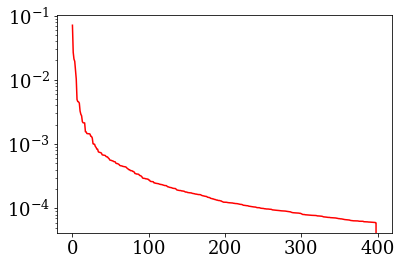

In [64]:
kNN = eva[sb_list,:][:,sb_list] # apparently have to do it like this. [sb_list,sblist] doesn't work
#kNN = eva[ndict:,ndict:]
#print(kNN)
ntot = len(kNN)
ifps, dfps = fps(kNN,400, 0)
#fifps, fdfps, fivor, frvor = fast_fps(eva,200, 0)
#print(ifps)
plt.semilogy(dfps,'r-')

In [65]:
nref = 200
kMM = kNN[ifps[:nref],ifps[:nref]]
print(ntot, nref)

kNM = kNN[:,ifps[:nref]]
kMM=kNN[:,ifps[:nref]][ifps[:nref]]

# prediction on the known possible structures in the dictionary
kXM = eva[:ndict,ifps[:nref]+ndict]

4598 200


0.261734162928466


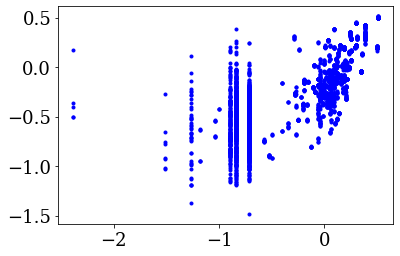

In [66]:
y_sb_train = entropy_basin[sb_list]

sparse_jitter = 1e-10
delta = np.var(y_sb_train)/(np.trace(kMM)/nref)
sigma = 0.01
sparseK = kMM * delta * sigma**2 +  np.dot(kNM.T,kNM)*delta**2
sparseY = delta*np.dot(delta*kNM.T,y_sb_train)
w_sb = np.linalg.solve(sparseK+np.eye(nref)*sparse_jitter, sparseY)
print(delta)

y_sb_pred = np.dot(kNM,w_sb)
y_sb_abs_error = np.sqrt((y_sb_train - y_sb_pred)**2.)
plt.plot(y_sb_train, y_sb_pred, 'b.')

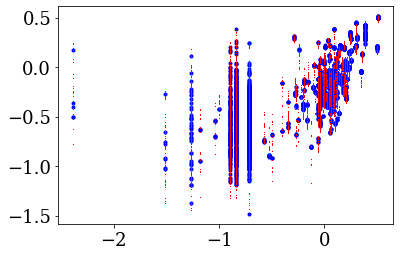

In [67]:
# error estimation using bootstrap
bslist_sb = []
nbs = 8
for ibs in range(nbs):
    idx = np.asarray(range(ntot))
    sbs = np.random.choice(idx, 800, replace =False)
    #print sbs
    subkNM = kNM[sbs,:]
    sparseK = kMM * delta * sigma**2 +  np.dot(subkNM.T,subkNM)*delta**2
    sparseY = delta*np.dot(delta*subkNM.T,y_sb_train[sbs])
    subw = np.linalg.solve(sparseK+np.eye(nref)*sparse_jitter, sparseY)
    suby_pred = np.dot(kNM,subw)
    bslist_sb.append({"selection": sbs, "w": subw,"prediction": suby_pred})
    
plt.plot(y_sb_train,y_sb_pred,'b.')
for ibs in range(nbs):
    plt.plot(y_sb_train,bslist_sb[ibs]['prediction'],'r,')

{'MAE': 0.17817422592515125, 'RMSE': 0.26188141942043164, 'SUP': 2.5077977748652858, 'R2': -0.6968757789829922, 'CORR': 0.41880679513848723}
[2.9368936  0.11339168]


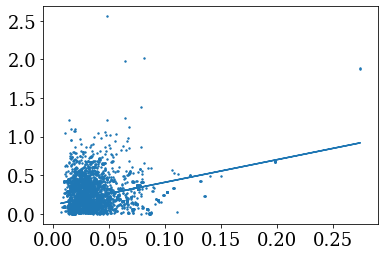

In [68]:
from asaplib.fit import get_score
# get the correlation coefficient between the true error and the predicted error
n_train = len(y_sb_train)
y_sb_pred_error = np.zeros(n_train)
for i in range(n_train):
    y_sb_pred_error[i] = np.std([bslist_sb[ibs]['prediction'][i] for ibs in range(nbs)])
print(get_score(y_sb_pred_error,y_sb_abs_error))

z = np.polyfit(y_sb_pred_error,y_sb_abs_error, 1)
print(z)
errorfit_sb = np.poly1d(z)
plt.scatter(y_sb_pred_error,y_sb_abs_error, vmin=0,vmax=100, marker='o',s=2)
plt.plot(y_sb_pred_error,errorfit_sb(y_sb_pred_error))

In [69]:
# prediction on the known possible structures in the dictionary
kXM = eva[:ndict,sb_list[ifps[:nref]]]

y_sb_test = np.dot(kXM,w_sb)
suby_sb_test = np.zeros((nbs,len(y_sb_test)))
for ibs in range(nbs):
    suby_sb_test[ibs,:]=np.dot(kXM,bslist_sb[ibs]['w'])

In [70]:
for i in range(ndict):
    cl = labels_db[i]
    if( cl >= 0): 
        # if the structure has been found, we take the mean of the enthalpy of the cluster
        #y_test_result[i,1] = cluster_min_enthalpy[labels_db[i]] # mean of enthalpy
        #y_test_result[i,2] = cluster_avg_enthalpy[labels_db[i]] -cluster_min_enthalpy[labels_db[i]]
        y_test_result[i,3] = est_entropylist[cl] # estimate of log(entropy)
        y_test_result[i,4] = error_est_entropy # error estimate of log(entropy)
    else:
        # if the structure hasn't been found, we use the KRR to predict its enthalpy
        #y_test_result[i,1] = y_enthalpy_test[i] # mean of enthalpy
        #y_test_result[i,2] = errorfit(np.std(suby_enthalpy_test[:,i])) # error estimate of enthalpy        
        y_test_result[i,3] = y_sb_test[i]
        y_test_result[i,4] = errorfit_sb(np.std(suby_sb_test[:,i]))+error_est_entropy
    
    
    print(i,cl, y_sb_test[i], dicttags[i], y_test_result[i,[3,4]])
    
y_test_result = y_test_result[y_test_result[:,1].argsort()]
y_test_result[:,5] = np.arange(len(y_test_result))

0 -1 -1.237805697639942 anatase [-1.2378057   1.16507016]
1 0 0.1815164504062068 baddeleyite [0.00788239 0.17470488]
2 1 0.19945524956028748 C2c [0.14841722 0.17470488]
3 -1 -0.3811455652330551 columbite [-0.38114557  0.49302122]
4 2 0.4790735655660683 cotunnite [0.50698632 0.17470488]
5 3 0.2798137430679617 fluorite [0.31237876 0.17470488]
6 4 0.3604579556351837 OIanalogue [0.09318813 0.17470488]
7 -1 -0.5761452292158538 OIphase [-0.57614523  0.53074329]
8 -1 -0.04507138174994907 Pca21 [-0.04507138  0.38151427]
9 5 0.1669018946624874 pyrite [0.18541948 0.17470488]
10 6 0.2459738907036808 ramsdelliteAnalogue [0.03041486 0.17470488]
11 -1 -0.7563161526556996 ramsdellite [-0.75631615  0.74622298]
12 -1 -0.3082638294165463 rutile [-0.30826383  0.49871151]
13 -1 -0.32955772127411365 0-a-P21c [-0.32955772  0.46388487]
14 7 0.04686958481215697 0-b-P21c [0.25592785 0.17470488]
15 8 -0.15365270533493458 40-a-Pnnm [-0.19779328  0.17470488]
16 9 0.42896162460851883 60-a-R3 [0.29911924 0.17470488

In [71]:
f = open("ML-predictions/ML-prediction-P-"+str(press)+"GPa.dat", "w")
f.write("# name enthalpy[kcal/TiO2] enthalpy_error[kcal/TiO2] entropy[log(frequency)] entropy_error ranking_by_enthalpy \n")
for i,y in enumerate(y_test_result):
    if (y[-1] > -1):
        f.write("%s %4.4f %4.4f %4.4f %4.4f %d %s\n"%(dicttags[i], y[1],y[2],y[3],y[4],y[5],'Found'))
    else:
        f.write("%s %4.4f %4.4f %4.4f %4.4f %d %s\n"%(dicttags[i], y[1],y[2],y[3],y[4],y[5],'NotFound'))
f.close()

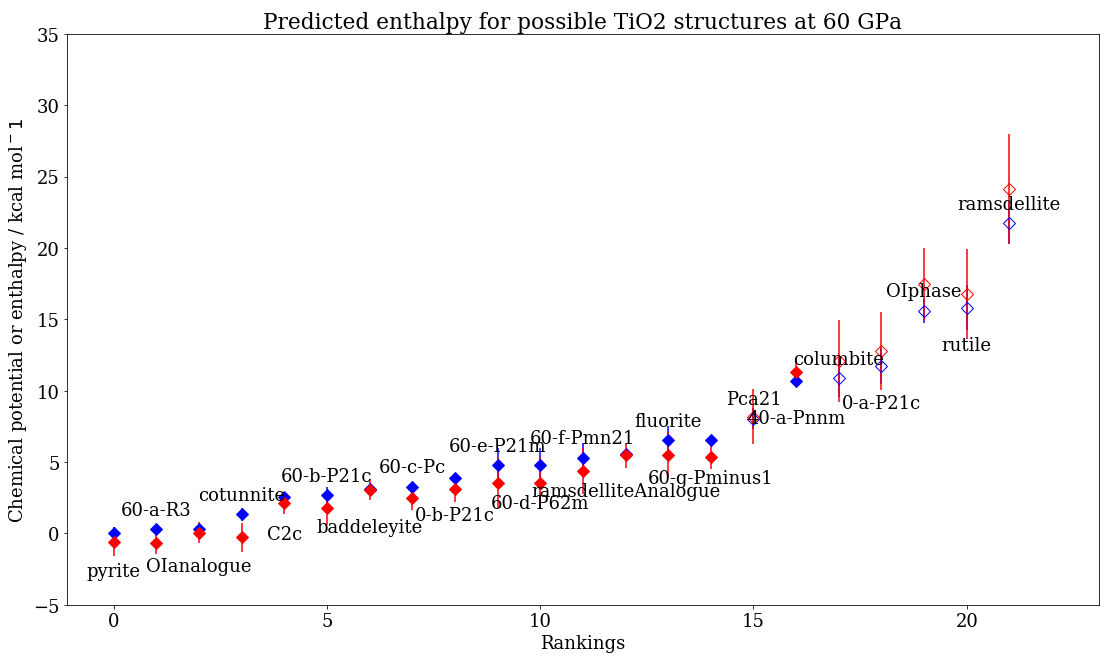

In [72]:
fig, ax = plt.subplots()

tnow = 1600
kbt = kb2kcalmol*tnow # in kcal/mol

for i, y in enumerate(y_test_result): 
    cl = y[-1]
    if(cl >= 0): 
        ax.errorbar(y[-2], y[1], yerr=y[2], 
             label='found', marker='D',c='blue', markersize=8)
        # predicted chemical potential
        ax.errorbar(y[-2], y[1]-kbt*y[3], 
                    yerr=y[2]+kbt*y[4], 
             label='found', marker='D',c='red', markersize=8)
        
        #ax.annotate(dicttags[y[0]], xy=(ii[-1]-0.5, ii[1]-2),color='black')
    else:
        ax.errorbar(y[-2], y[1], yerr=y[2], 
             label='not found', marker='D',c='blue',markerfacecolor='none',
             markeredgecolor='blue',markersize=8)
                # predicted chemical potential
        ax.errorbar(y[-2], y[1]-kbt*y[3], 
                    yerr=y[2]+kbt*y[4], 
             label='not found', marker='D',c='red',markerfacecolor='none',  markeredgecolor='red', markersize=8)
        
    ax.annotate(dicttags[int(y[0])], xy=(y[-2], y[1]+4*(y[-2]%2)-3),
                color='black',horizontalalignment='center', )

ax.set_ylim(-5,35)
        
#ax.legend()
plt.xlabel('Rankings')
plt.ylabel('Chemical potential or enthalpy / kcal mol$^-1$')
plt.title('Predicted enthalpy for possible TiO2 structures at '+press+' GPa')
fig.set_size_inches(18.5, 10.5)

fig.savefig('figures/pred-H-'+press+'GPa.png')